In [1]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
#import packages and classes
import os
import cv2
import numpy as np
from keras.utils.np_utils import to_categorical
from keras.layers import  MaxPooling2D
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D, BatchNormalization, RepeatVector
from keras.layers import Convolution2D
from keras.models import Sequential
import pickle
from tensorflow.keras.applications import VGG19 #load VGG19 class
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
from keras.layers import LSTM #load lstm class
from keras.layers import Bidirectional, GRU #load bidirectional and GRU class
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
#define function to get label using animal name and then print different types of animals found in dataset
labels = []
path = 'Animals'
for root, dirs, directory in os.walk(path):
    for j in range(len(directory)):
        name = os.path.basename(root)
        if name not in labels:
            labels.append(name.strip())

def getLabel(name):
    index = -1
    for i in range(len(labels)):
        if labels[i] == name:
            index = i
            break
    return index
print("Labels found in Dataset : "+str(labels))

Labels found in Dataset : ['Cheetah', 'Jaguar', 'Leopard', 'Lion', 'Tiger']


In [5]:
#load dataset images
if os.path.exists('model/X.txt.npy'):
    X = np.load('model/X.txt.npy')
    Y = np.load('model/Y.txt.npy')
else:
    X = []
    Y = []
    for root, dirs, directory in os.walk(path):#loop all images in dataset
        for j in range(len(directory)):
            name = os.path.basename(root)
            if 'Thumbs.db' not in directory[j]:
                img = cv2.imread(root+"/"+directory[j])#read image
                img = cv2.resize(img, (32,32))#resize image
                im2arr = np.array(img)
                im2arr = im2arr.reshape(32,32,3)#extract red, green, blue 3 features from iamges
                X.append(im2arr)#add image features to X
                label = getLabel(name)
                Y.append(label) #add label to Y
    X = np.asarray(X)#save X as training features
    Y = np.asarray(Y)
    np.save('model/X.txt',X)
    np.save('model/Y.txt',Y)
print("Dataset images loading completed")
print("Total images found in Dataset : "+str(X.shape[0]))

Dataset images loading completed
Total images found in Dataset : 1833


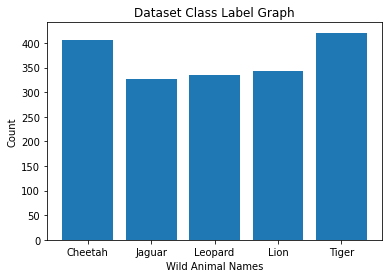

In [6]:
#plot graph of different animals found in dataset
unique, count = np.unique(Y, return_counts = True)
height = count
bars = labels
y_pos = np.arange(len(bars))
plt.bar(y_pos, height)
plt.xticks(y_pos, bars)
plt.xlabel("Wild Animal Names")
plt.ylabel("Count")
plt.title("Dataset Class Label Graph")
plt.show()

In [7]:
#dataset preprocessing such as shuffling and normalization
X = X.astype('float32')
X = X/255 #normalizing images
indices = np.arange(X.shape[0])
np.random.shuffle(indices)#shuffling images
X = X[indices]
Y = Y[indices]
Y = to_categorical(Y)
print("Dataset Normalization & Shuffling Process completed")

Dataset Normalization & Shuffling Process completed


In [8]:
#now splitting dataset into train & test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2) #split dataset into train and test
print()
print("Dataset train & test split as 80% dataset for training and 20% for testing")
print("Training Size (80%): "+str(X_train.shape[0])) #print training and test size
print("Testing Size (20%): "+str(X_test.shape[0]))
print()


Dataset train & test split as 80% dataset for training and 20% for testing
Training Size (80%): 1466
Testing Size (20%): 367



In [9]:
#define global variables to calculate and store accuracy and other metrics
precision = []
recall = []
fscore = []
accuracy = []

ML_Model = []
acc = []
prec = []
rec = []
f1 = []

#function to call for storing the results
def storeResults(model, a,b,c,d):
    ML_Model.append(model)
    acc.append(round(a, 3))
    prec.append(round(b, 3))
    rec.append(round(c, 3))
    f1.append(round(d, 3))

In [10]:
#function to calculate various metrics such as accuracy, precision etc
def calculateMetrics(algorithm, predict, testY):
    p = precision_score(testY, predict,average='macro') * 100
    r = recall_score(testY, predict,average='macro') * 100
    f = f1_score(testY, predict,average='macro') * 100
    a = accuracy_score(testY,predict)*100     
    print()
    print(algorithm+' Accuracy  : '+str(a))
    print(algorithm+' Precision   : '+str(p))
    print(algorithm+' Recall      : '+str(r))
    print(algorithm+' FMeasure    : '+str(f))    
    accuracy.append(a)
    precision.append(p)
    recall.append(r)
    fscore.append(f)
    conf_matrix = confusion_matrix(testY, predict) 
    plt.figure(figsize =(5, 5)) 
    ax = sns.heatmap(conf_matrix, xticklabels = labels, yticklabels = labels, annot = True, cmap="viridis" ,fmt ="g");
    ax.set_ylim([0,len(labels)])
    plt.title(algorithm+" Confusion matrix") 
    plt.ylabel('True class') 
    plt.xlabel('Predicted class') 
    plt.show()

# CNN


Existing CNN Accuracy  : 94.27792915531336
Existing CNN Precision   : 94.63951568519538
Existing CNN Recall      : 94.11336672397522
Existing CNN FMeasure    : 94.24073395454633


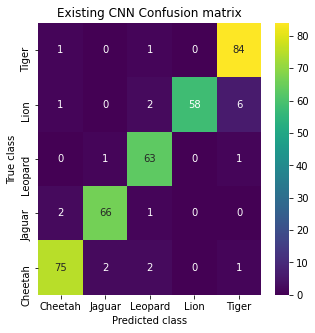

In [11]:
#now train existing CNN algortihm
cnn = Sequential()
#create CNN layer with 32 neurons to filter dataset 32 times
cnn.add(Convolution2D(32, (3 , 3), input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3]), activation = 'relu'))
#max pool layer to collect optimize/filtered features from previous CNN layer
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Convolution2D(32, (3, 3), activation = 'relu'))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Flatten())
cnn.add(Dense(units = 256, activation = 'relu'))
#define output layers
cnn.add(Dense(units = y_train.shape[1], activation = 'softmax'))
#train and compile the model
cnn.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
if os.path.exists("model/cnn_weights.hdf5") == False:
    model_check_point = ModelCheckpoint(filepath='model/cnn_weights.hdf5', verbose = 1, save_best_only = True)
    hist = cnn.fit(X_train, y_train, batch_size = 32, epochs = 15, validation_data=(X_test, y_test), callbacks=[model_check_point], verbose=1)
    f = open('model/cnn_history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()    
else:
    cnn.load_weights("model/cnn_weights.hdf5")
#perform prediction on test data    
predict = cnn.predict(X_test)
predict = np.argmax(predict, axis=1)
test = np.argmax(y_test, axis=1)
calculateMetrics("Existing CNN", predict, test)#call function to calculate accuracy and other metrics

In [12]:
cnn_acc = (accuracy_score(predict, test))
cnn_prec = precision_score(predict, test,average='weighted')
cnn_rec = recall_score(predict, test,average='weighted')
cnn_f1 = f1_score(predict, test,average='weighted')

In [13]:
storeResults('Existing CNN',cnn_acc,cnn_prec,cnn_rec,cnn_f1)

# VGG19 + BiLSTM

Epoch 1/20
46/46 [==============================] - 19s 35ms/step - loss: 1.5604 - accuracy: 0.2875 - val_loss: 1.3084 - val_accuracy: 0.4496
Epoch 2/20
46/46 [==============================] - 0s 9ms/step - loss: 1.2257 - accuracy: 0.5135 - val_loss: 1.1418 - val_accuracy: 0.5450
Epoch 3/20
46/46 [==============================] - 0s 9ms/step - loss: 0.9494 - accuracy: 0.6056 - val_loss: 0.8816 - val_accuracy: 0.6349
Epoch 4/20
46/46 [==============================] - 0s 9ms/step - loss: 0.7809 - accuracy: 0.7099 - val_loss: 0.7828 - val_accuracy: 0.6894
Epoch 5/20
46/46 [==============================] - 0s 9ms/step - loss: 0.7139 - accuracy: 0.7224 - val_loss: 0.6905 - val_accuracy: 0.7275
Epoch 6/20
46/46 [==============================] - 0s 9ms/step - loss: 0.5642 - accuracy: 0.7799 - val_loss: 0.6331 - val_accuracy: 0.7548
Epoch 7/20
46/46 [==============================] - 0s 9ms/step - loss: 0.4949 - accuracy: 0.8148 - val_loss: 0.5800 - val_accuracy: 0.7684
Epoch 8/20
46/46 [

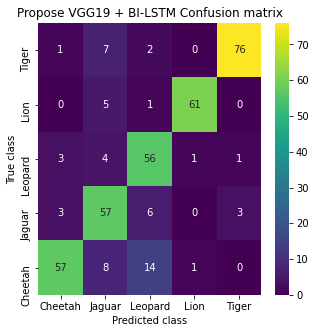

In [16]:
#now train propose VGG19 + BI-LSTM algorithm
#create vgg19 object
vgg = VGG19(include_top=False, weights='imagenet', input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]))
for layer in vgg.layers:
    layer.trainable = False
#creating deep learning object    
vgg_bilstm = Sequential()
#adding vgg to animal training deep learning model
vgg_bilstm.add(vgg)
#adding cnn layer to filter animal images features
vgg_bilstm.add(Convolution2D(32, (1 , 1), input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3]), activation = 'relu'))
vgg_bilstm.add(MaxPooling2D(pool_size = (1, 1)))
vgg_bilstm.add(Convolution2D(32, (1, 1), activation = 'relu'))
vgg_bilstm.add(MaxPooling2D(pool_size = (1, 1)))
vgg_bilstm.add(Flatten())
vgg_bilstm.add(RepeatVector(2))
#adding BI-LSTM layer
vgg_bilstm.add(Bidirectional(LSTM(32)))
#deining output layer
vgg_bilstm.add(Dense(units = 256, activation = 'relu'))
vgg_bilstm.add(Dense(units = y_train.shape[1], activation = 'softmax'))
#compiling and training model
vgg_bilstm.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
#if os.path.exists("model/vgg_bilstm_weights.hdf5") == False:
    #model_check_point = ModelCheckpoint(filepath='model/vgg_bilstm_weights.hdf5', verbose = 1, save_best_only = True)
hist = vgg_bilstm.fit(X_train, y_train, batch_size = 32, epochs = 20, validation_data=(X_test, y_test), verbose=1)
    #f = open('model/vgg_bilstm_history.pckl', 'wb')
    #pickle.dump(hist.history, f)
    #f.close()    
#else:
    #vgg_bilstm.load_weights("model/vgg_bilstm_weights.hdf5")
#perform prediction on test data
predict = vgg_bilstm.predict(X_test)
predict = np.argmax(predict, axis=1)
test = np.argmax(y_test, axis=1)
calculateMetrics("Propose VGG19 + BI-LSTM", predict, test)#call function to calculate accuracy and other metrics

In [17]:
cnn_acc = (accuracy_score(predict, test))
cnn_prec = precision_score(predict, test,average='weighted')
cnn_rec = recall_score(predict, test,average='weighted')
cnn_f1 = f1_score(predict, test,average='weighted')

storeResults('Propose VGG19 + BI-LSTM',cnn_acc,cnn_prec,cnn_rec,cnn_f1)

# Extension CNN + Bidirectional GRU

Epoch 1/20
46/46 [==============================] - 3s 22ms/step - loss: 1.5801 - accuracy: 0.2501 - val_loss: 1.4257 - val_accuracy: 0.4100
Epoch 2/20
46/46 [==============================] - 0s 9ms/step - loss: 1.3959 - accuracy: 0.4016 - val_loss: 1.2781 - val_accuracy: 0.4720
Epoch 3/20
46/46 [==============================] - 0s 8ms/step - loss: 1.2681 - accuracy: 0.4636 - val_loss: 1.1126 - val_accuracy: 0.5559
Epoch 4/20
46/46 [==============================] - 0s 9ms/step - loss: 1.0968 - accuracy: 0.5464 - val_loss: 0.8986 - val_accuracy: 0.6548
Epoch 5/20
46/46 [==============================] - 0s 8ms/step - loss: 0.9421 - accuracy: 0.6369 - val_loss: 0.9600 - val_accuracy: 0.6078
Epoch 6/20
46/46 [==============================] - 0s 8ms/step - loss: 0.8120 - accuracy: 0.6913 - val_loss: 0.5760 - val_accuracy: 0.7920
Epoch 7/20
46/46 [==============================] - 0s 8ms/step - loss: 0.5584 - accuracy: 0.7918 - val_loss: 0.4090 - val_accuracy: 0.8649
Epoch 8/20
46/46 [=

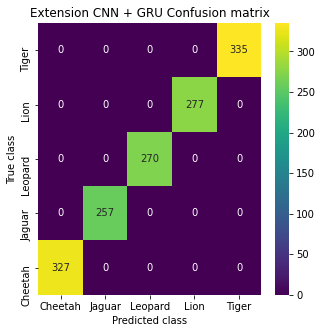

In [21]:
#now train extension CNN + Bidirectional GRU
#creating deep learning object  
extension_gru = Sequential()
#adding cnn layer to filter animal images features
extension_gru.add(Convolution2D(32, (3 , 3), input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3]), activation = 'relu'))
extension_gru.add(MaxPooling2D(pool_size = (2, 2)))
extension_gru.add(Convolution2D(32, (3, 3), activation = 'relu'))
extension_gru.add(MaxPooling2D(pool_size = (2, 2)))
extension_gru.add(Flatten())
extension_gru.add(RepeatVector(2))
#adding BI-GRU layer
extension_gru.add(Bidirectional(GRU(32)))
#deining output layer
extension_gru.add(Dense(units = 256, activation = 'relu'))
extension_gru.add(Dense(units = y_train.shape[1], activation = 'softmax'))
#compiling and training model
extension_gru.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
#if os.path.exists("model/extension_weights.hdf5") == False:
    #model_check_point = ModelCheckpoint(filepath='model/extension_weights.hdf5', verbose = 1, save_best_only = True)
hist = extension_gru.fit(X_train, y_train, batch_size = 32, epochs = 20, validation_data=(X_test, y_test),  verbose=1)
    #f = open('model/extension_history.pckl', 'wb')
    #pickle.dump(hist.history, f)
    #f.close()    
#else:
    #extension_gru.load_weights("model/extension_weights.hdf5")
#perform prediction on test data
predict = extension_gru.predict(X_test)
predict = np.argmax(predict, axis=1)
test = np.argmax(y_test, axis=1)
calculateMetrics("Extension CNN + BiGRU", predict, test)#call function to calculate accuracy and other metrics

In [22]:
cnn_acc = (accuracy_score(predict, test))
cnn_prec = precision_score(predict, test,average='weighted')
cnn_rec = recall_score(predict, test,average='weighted')
cnn_f1 = f1_score(predict, test,average='weighted')

storeResults('Extension CNN + GRU',cnn_acc,cnn_prec,cnn_rec,cnn_f1)

# Comparison

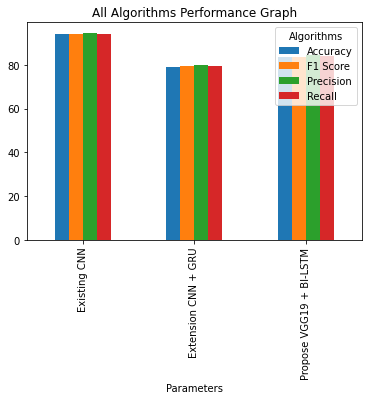

In [23]:
import pandas as pd
df = pd.DataFrame([['Existing CNN','Precision',precision[0]],['Existing CNN','Recall',recall[0]],['Existing CNN','F1 Score',fscore[0]],['Existing CNN','Accuracy',accuracy[0]],
                   ['Propose VGG19 + BI-LSTM','Precision',precision[1]],['Propose VGG19 + BI-LSTM','Recall',recall[1]],['Propose VGG19 + BI-LSTM','F1 Score',fscore[1]],['Propose VGG19 + BI-LSTM','Accuracy',accuracy[1]],
                   ['Extension CNN + GRU','Precision',precision[2]],['Extension CNN + GRU','Recall',recall[2]],['Extension CNN + GRU','F1 Score',fscore[2]],['Extension CNN + GRU','Accuracy',accuracy[2]],
                  ],columns=['Parameters','Algorithms','Value'])
df.pivot("Parameters", "Algorithms", "Value").plot(kind='bar')
plt.title("All Algorithms Performance Graph")
plt.show()

In [26]:
#creating dataframe
import pandas as pd
result = pd.DataFrame({ 'ML Model' : ML_Model,
                        'Accuracy' : acc,
                       'Precision': prec,
                       'Recall'   : rec,
                        'f1_score' : f1,
                      })

In [27]:
result

,ML Model,Accuracy,Precision,Recall,f1_score
0,Existing CNN,0.943,0.946,0.943,0.943
1,Propose VGG19 + BI-LSTM,0.837,0.841,0.837,0.834
2,Extension CNN + GRU,1.000,1.000,1.000,1.000


In [28]:
extension_gru.save('model.h5')

In [30]:
classifier = ML_Model
y_pos = np.arange(len(classifier))

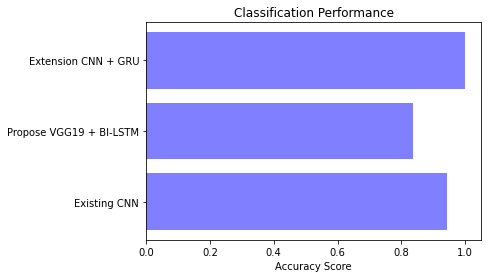

In [31]:
import matplotlib.pyplot as plt2
plt2.barh(y_pos, acc, align='center', alpha=0.5,color='blue')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Accuracy Score')
plt2.title('Classification Performance')
plt2.show()

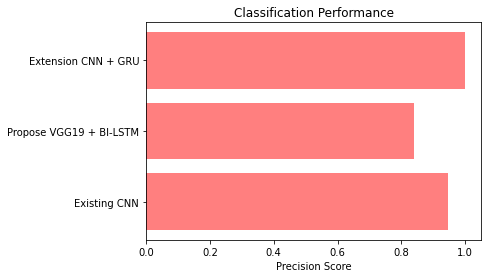

In [32]:
plt2.barh(y_pos, prec, align='center', alpha=0.5,color='red')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Precision Score')
plt2.title('Classification Performance')
plt2.show()

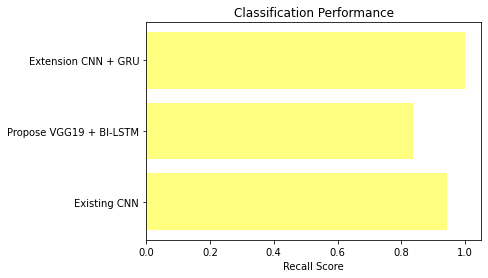

In [33]:
plt2.barh(y_pos, rec, align='center', alpha=0.5,color='yellow')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Recall Score')
plt2.title('Classification Performance')
plt2.show()

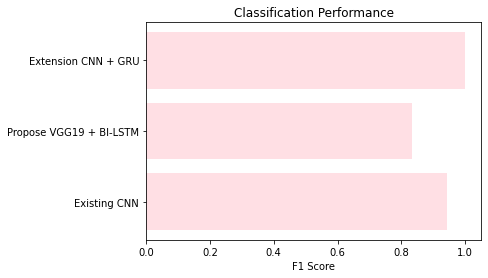

In [34]:
plt2.barh(y_pos, f1, align='center', alpha=0.5,color='pink')
plt2.yticks(y_pos, classifier)
plt2.xlabel('F1 Score')
plt2.title('Classification Performance')
plt2.show()